In [ ]:
import numpy as np
import pandas as pd
import pandas

from sklearn.preprocessing import normalize # , LabelEncoder

# Read the info about features
print('Reading feature info...')
data_info = pandas.read_csv(r"/content/NUSW-NB15_features.csv", encoding = "ISO-8859-1", header=None).values
features = data_info[1:-2,:]
feature_names = features[:, 1]  # Names of the features in a list
feature_types = np.array([item.lower() for item in features[:, 2]])  # The types of the corresponding features in 'features_names'

# index arrays for different types of features
print('Finding column indices for feature types...')
nominal_cols = np.where(feature_types == "nominal")[0]
integer_cols = np.where(feature_types == "integer")[0]
binary_cols = np.where(feature_types == "binary")[0]
float_cols = np.where(feature_types == "float")[0]

# arrays for names of the different types of features
nominal_names = feature_names[nominal_cols]
integer_names = feature_names[integer_cols]
binary_names = feature_names[binary_cols]
float_names = feature_names[float_cols]

print('Reading csv files...')
dataframe1 = pandas.read_csv(r"/content/UNSW-NB15_1.csv", header=None)
dataframe2 = pandas.read_csv(r"/content/UNSW-NB15_2.csv", header=None)
dataframe3 = pandas.read_csv(r"/content/UNSW-NB15_3.csv", header=None)
dataframe4 = pandas.read_csv(r"/content/UNSW-NB15_4.csv", header=None)

print('Concatenating...')
dataframe = pandas.concat([dataframe1, dataframe2, dataframe3, dataframe4])

del dataframe1
del dataframe2
del dataframe3
del dataframe4

print('Preprocessing...')
print('Converting data...')
dataframe[integer_cols] = dataframe[integer_cols].apply(pd.to_numeric, errors='coerce')
dataframe[binary_cols] = dataframe[binary_cols].apply(pd.to_numeric, errors='coerce')
dataframe[float_cols] = dataframe[float_cols].apply(pd.to_numeric, errors='coerce')
dataframe[48] = pd.to_numeric(dataframe[48], errors='coerce')
#dataframe[nominal_cols] = dataframe[nominal_cols].astype(str)

print('Replacing NaNs...')
dataframe.loc[:,47] = dataframe.loc[:,47].replace(np.nan,'normal', regex=True).apply(lambda x: x.strip().lower())
dataframe.loc[:,binary_cols] = dataframe.loc[:,binary_cols].replace(np.nan, 0, regex=True)
dataframe.loc[:,37:39] = dataframe.loc[:,37:39].replace(np.nan, 0, regex=True)
# dataframe.loc[:,float_cols] = dataframe.loc[:,float_cols].replace(np.nan, 0, regex=True)

print('Stripping nominal columns and setting them lower case...')
dataframe.loc[:,nominal_cols] = dataframe.loc[:,nominal_cols].applymap(lambda x: x.strip().lower())

print('Changing targets \'backdoors\' to \'backdoor\'...')
dataframe.loc[:,47] = dataframe.loc[:,47].replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())

dataset = dataframe.values

del dataframe

# Subsets of the dataset which have data that is only of the corresponding data type (nominal, integer etc)
# Columns don't include the target classes (the two last columns of the dataset)
print('Slicing dataset...')
nominal_x = dataset[:, nominal_cols][:,:]
integer_x = dataset[:, integer_cols][:,:].astype(np.float32)
binary_x = dataset[:, binary_cols][:,:].astype(np.float32)
float_x = dataset[:, float_cols][:,:].astype(np.float32)
# aon_x = dataset[:, 48][np.newaxis,:].astype(np.float32).transpose()  # Attack or not (binary)

# Make nominal (textual) data binary vectors
print('Vectorizing nominal data...')
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
# D = [{'foo': 1, 'bar': 2}, {'foo': 3, 'baz': 1}]
D = map(lambda dataline: dict(zip(nominal_names, dataline)), nominal_x)
labeled_nominal_x = v.fit_transform(D).astype(np.float32)
del nominal_x

print('Concatenating X...')
X = np.concatenate((integer_x, labeled_nominal_x, float_x, binary_x), axis=1)

del integer_x
del labeled_nominal_x
del float_x
del binary_x

# Find rows that have NaNs
print('Removing NaNs if any...')
nan_indices = []
for feature_i in range(X.shape[1]):
    nan_indices.extend(list(np.where(np.isnan(X[:, feature_i]))[0]))
nan_indices = np.unique(nan_indices)

# Remove rows that have NaNs
X_no_nans = np.delete(X, nan_indices, axis=0)

del X

print('Normalizing X...')
normalized_X = normalize(X_no_nans, copy=False)

del X_no_nans


data_dim = normalized_X.shape
print('Data dimensions are', data_dim)

print('Creating target Y matrix...')
Y = np.delete(dataset[:, -2], nan_indices)
Y_A = np.delete(dataset[:, -1], nan_indices).astype(np.int16) # Is attack or not

del dataset

'''
# Remove same rows as in X to have correct y's
Y_no_nans = np.delete(Y, nan_indices, axis=0)
'''
print('Vectorizing Y labels...')
D = [{'attack_cat': y} for y in Y]
labeled_Y = v.fit_transform(D)

del D

print('Saving normalized X and labeled Y to HDF5')
import h5py
h5f = h5py.File('data.h5', 'w')
h5f.create_dataset('normalized_X', data=normalized_X)
h5f.create_dataset('labeled_Y', data=labeled_Y)
dt = h5py.special_dtype(vlen=str)
h5f.create_dataset('Y', data=Y, dtype=dt)
h5f.create_dataset('Y_A', data=Y_A)
h5f.close()

del Y
del normalized_X
del labeled_Y

Reading feature info...
Finding column indices for feature types...
Reading csv files...


<ipython-input-1-503a5709a0e8>:28: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe1 = pandas.read_csv(r"/content/UNSW-NB15_1.csv", header=None)
<ipython-input-1-503a5709a0e8>:29: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe2 = pandas.read_csv(r"/content/UNSW-NB15_2.csv", header=None)


Concatenating...
Preprocessing...
Converting data...
Replacing NaNs...
Stripping nominal columns and setting them lower case...


<ipython-input-1-503a5709a0e8>:56: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataframe.loc[:,nominal_cols] = dataframe.loc[:,nominal_cols].applymap(lambda x: x.strip().lower())


Changing targets 'backdoors' to 'backdoor'...
Slicing dataset...
Vectorizing nominal data...
Concatenating X...
Removing NaNs if any...
Normalizing X...
Data dimensions are (2539739, 294)
Creating target Y matrix...
Vectorizing Y labels...
Saving normalized X and labeled Y to HDF5


Loading normalized data from HDF5...
Splitting X to test and train datasets...
Select max 5000 samples for training...
b'analysis' : training samples = 2409.0 | total samples = 2677
b'backdoor' : training samples = 2096.0 | total samples = 2329
b'dos' : training samples = 5000 | total samples = 16353
b'exploits' : training samples = 5000 | total samples = 44525
b'fuzzers' : training samples = 5000 | total samples = 24246
b'generic' : training samples = 5000 | total samples = 215481
b'normal' : training samples = 5000 | total samples = 2218456
b'reconnaissance' : training samples = 5000 | total samples = 13987
b'shellcode' : training samples = 1359.0 | total samples = 1511
b'worms' : training samples = 156.0 | total samples = 174
Number of categories is 10 | Total samples in categories:
| 0: 2677
|1: 2329
|2: 16353
|3: 44525
|4: 24246
|5: 215481
|6: 2218456
|7: 13987
|8: 1511
|9: 174
normal samples for rf: 0
normal samples for nn: 0
Finding feature importances with ExtraTreesClassifier


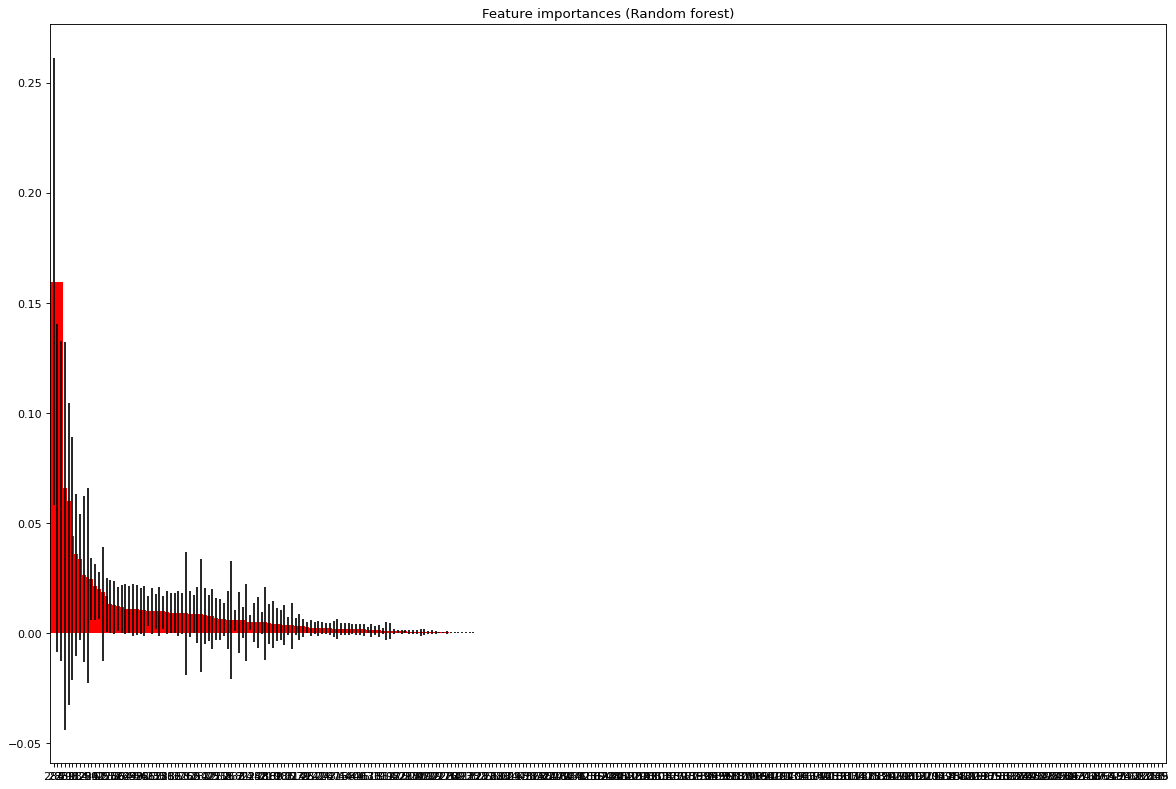

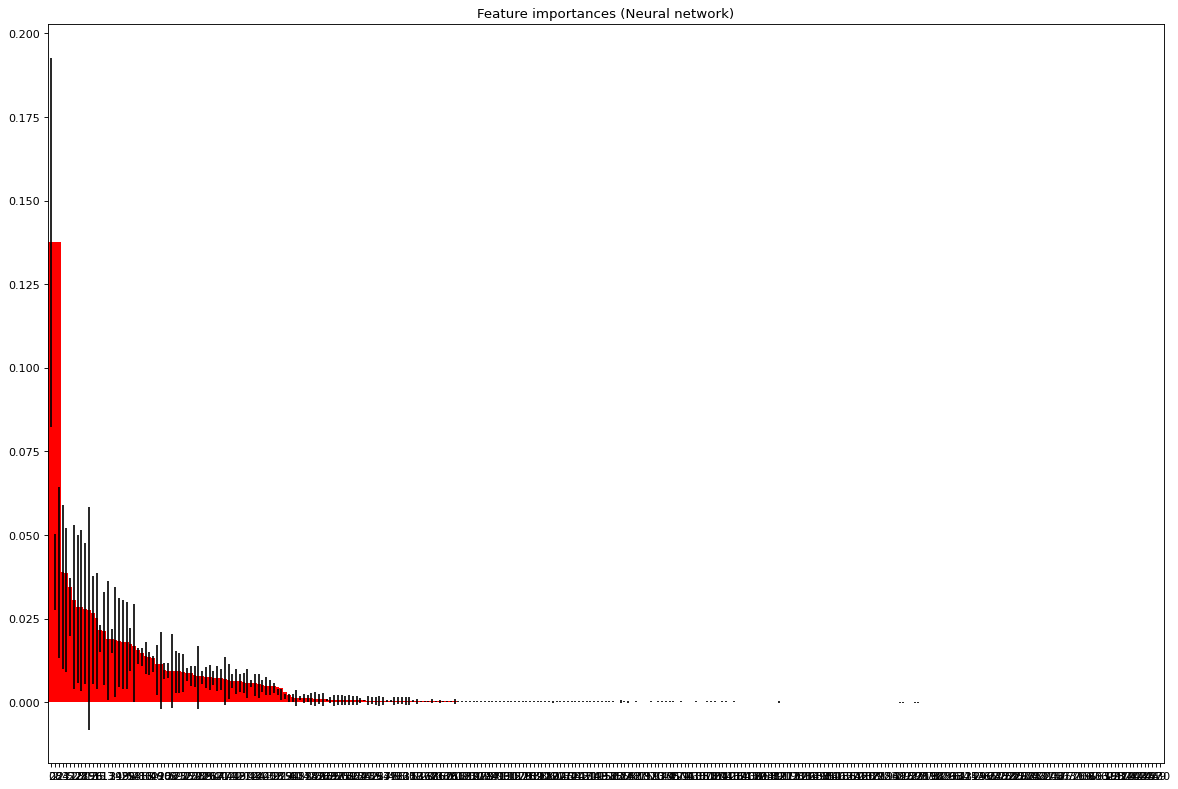

Saving X and Y to HDF5


In [ ]:
print('Loading normalized data from HDF5...')
import h5py
h5f = h5py.File('data.h5', 'r')
normalized_X = h5f['normalized_X'][:]
labeled_Y = h5f['labeled_Y'][:]
Y = h5f['Y'][:]
Y_A = h5f['Y_A'][:]
h5f.close()


print('Splitting X to test and train datasets...')
# X_test, X_train, Y_test, Y_train = []
rf_normal_inds = []
nn_normal_inds = []
inds = []

attack_cats = np.unique(Y)
cat_sizes = []
np.random.seed(1337)
max_training_samples = 5000
print('Select max', max_training_samples, 'samples for training...')
for cat in attack_cats:
    indices = np.ix_(Y == cat)[0]
    # total_num_of_samples = indices.shape[0]
    np.random.shuffle(indices)
    if cat == 'normal':
        len_of_subset = min(np.floor(len(indices)*0.9), 31000)
        rf_normal_inds = indices[:len_of_subset]
        nn_normal_inds = indices[:len_of_subset][:max_training_samples]
        cat_size = len(indices)
        print(cat, ': training samples =', len_of_subset, '| total samples =', cat_size)
    else:
        len_of_subset = min(np.floor(len(indices)*0.9), max_training_samples)

        cat_size = len(indices)
        print(cat, ': training samples =', len_of_subset, '| total samples =', cat_size)
        cat_sizes.append(cat_size)
        #inds.extend(oversampled_indices)
        inds.extend(indices[:int(len_of_subset)])


print('Number of categories is', len(cat_sizes), '| Total samples in categories:\n|', '\n|'.join([str(i)+': '+str(c) for i, c in enumerate(cat_sizes)]))
print('normal samples for rf:', len(rf_normal_inds))
print('normal samples for nn:', len(nn_normal_inds))

# Attack or not learning data
rf_inds = []
rf_inds.extend(inds)
rf_inds.extend(rf_normal_inds)
X_rf_train = normalized_X[rf_inds, :]
X_rf_test = np.delete(normalized_X, rf_inds, axis=0)

Y_rf_train = Y_A[rf_inds]
Y_rf_test = np.delete(Y_A, rf_inds, axis=0)

# Category learning data
nn_inds = []
nn_inds.extend(inds)
nn_inds.extend(nn_normal_inds)
X_nn_train = normalized_X[nn_inds, :]
# Remove rf indices because nn indices is a subset and we dont want to test and train with same data
X_nn_test = np.delete(normalized_X, rf_inds, axis=0)

del normalized_X

Y_nn_train = labeled_Y[nn_inds]
Y_nn_train_string = Y[nn_inds]

Y_nn_test = np.delete(labeled_Y, rf_inds, axis=0)
Y_nn_test_string = np.delete(Y, rf_inds, axis=0)

del labeled_Y
del Y

Y_nn_A_train = Y_A[nn_inds]
Y_nn_A_test = np.delete(Y_A, rf_inds, axis=0)

del Y_A

print('Finding feature importances with ExtraTreesClassifier')
from sklearn.ensemble import ExtraTreesClassifier

def find_importances(X_train, Y_train):
    model = ExtraTreesClassifier()
    model = model.fit(X_train, Y_train)

    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]  # Top ranking features' indices
    return importances, indices, std

import matplotlib.pyplot as plt
# Plot the feature importances of the forest
def plot_feature_importances(X_train, importances, indices, std, title):
   #tagy
#     for f in range(X_train.shape[1]):
#         print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    plt.figure(num=None, figsize=(18, 12), dpi=80, facecolor='w', edgecolor='k')
    plt.title(title)
    width=5
    plt.bar(range(X_train.shape[1]), importances[indices],
          width=5, color="r", yerr=std[indices], align="center") #tagy 1.5 > .8
    plt.xticks(range(X_train.shape[1]), indices)
    #plt.axis('tight')
    plt.xlim([-1, X_train.shape[1]]) # -1 tagy
    plt.show()



rf_importances, rf_indices, rf_std = find_importances(X_rf_train, Y_rf_train)

plot_feature_importances(X_rf_train, rf_importances, rf_indices, rf_std, title='Feature importances (Random forest)')

# Neural network is classified with correct 'attack or not' labels
X_nn_train = np.concatenate((Y_nn_A_train[:,np.newaxis], X_nn_train), axis=1)
nn_importances, nn_indices, nn_std = find_importances(X_nn_train,
                                                      Y_nn_train)
plot_feature_importances(X_nn_train,
                        nn_importances, nn_indices, nn_std, title='Feature importances (Neural network)')

NB_RF_FEATURES = 10
NB_NN_FEATURES = 25

reduced_X_nn_train = X_nn_train[:, nn_indices[0:NB_NN_FEATURES]]
reduced_Y_nn_train = Y_nn_train
reduced_Y_nn_train_string = Y_nn_train_string
reduced_Y_nn_test_string = Y_nn_test_string
reduced_Y_nn_A_train = Y_nn_A_train

# Test set has 1 less because we get the one from RF

reduced_X_nn_test = X_nn_test[:, nn_indices[1:NB_NN_FEATURES]]
reduced_Y_nn_test = Y_nn_test


reduced_X_rf_train = X_rf_train[:, rf_indices[0:NB_RF_FEATURES]]
reduced_Y_rf_train = Y_rf_train

reduced_X_rf_test = X_rf_test[:, rf_indices[0:NB_RF_FEATURES]]
reduced_Y_rf_test = Y_rf_test



print('Saving X and Y to HDF5')
import h5py
h5f = h5py.File('datasets.h5', 'w')
h5f.create_dataset('X_rf_train', data=reduced_X_rf_train)
h5f.create_dataset('X_rf_test',  data=reduced_X_rf_test)
h5f.create_dataset('Y_rf_train', data=reduced_Y_rf_train)
h5f.create_dataset('Y_rf_test',  data=reduced_Y_rf_test)

h5f.create_dataset('X_nn_train', data=reduced_X_nn_train)
h5f.create_dataset('X_nn_test',  data=reduced_X_nn_test)
h5f.create_dataset('Y_nn_train', data=reduced_Y_nn_train)
h5f.create_dataset('Y_nn_test',  data=reduced_Y_nn_test)
dt = h5py.special_dtype(vlen=str)
h5f.create_dataset('Y_nn_train_string', data=reduced_Y_nn_train_string, dtype=dt)
h5f.create_dataset('Y_nn_test_string', data=reduced_Y_nn_test_string, dtype=dt)

h5f.create_dataset('Y_nn_A_train', data=reduced_Y_nn_A_train)
h5f.create_dataset('Y_nn_A_test', data=Y_nn_A_test)

h5f.close()

In [ ]:
# confusion matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    cm = confusion_matrix(y_test, y_pred)
    # np.set_printoptions(precision=2)


    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{0:.4f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



    #Roc


def plot_roc_curve(Y_test, Y_pred, nb_classes, class_index, title='Receiver operating characteristic'):
    from sklearn import metrics
    import matplotlib.pyplot as plt
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(nb_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(Y_test[:, i], Y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(Y_test.ravel(), Y_pred.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

    #plt.figure()
    lw = 2
    plt.plot(fpr[class_index], tpr[class_index], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[class_index])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

    #epoch history


def plot_hist(hist, metrics, num=None):
    import matplotlib.pyplot as plt
    if num is not None:
        fig = plt.figure(num)
    else:
        fig = plt.figure()
    ax1 = fig.add_subplot(111)
    for metric in metrics:
        ax1.plot(hist.history[metric], label=metric)
    # plt.plot(history.history['val_acc'])
    # ax.ylabel(metric)
    plt.title('model history')
    plt.xlabel('epoch')
    #plt.legend(['train', 'test'], loc='upper left')
    plt.legend(loc='upper right');
    plt.show()

In [ ]:
# Install necessary libraries
!pip install keras
!pip install tensorflow==2.11.0
!pip install scikit-learn
!pip install matplotlib
!pip install h5py
!pip install mlxtend


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 28.3 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
  Attempting uninstall: keras
    Found existing installation: kera

Loading normalized data from HDF5...
Training ExtraTreesClassifier for "attack or not" labels...
Testing accuracy...
0.983249318314076
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99   2213456
         1.0       0.87      1.00      0.93    290263

    accuracy                           0.98   2503719
   macro avg       0.94      0.99      0.96   2503719
weighted avg       0.99      0.98      0.98   2503719

TP: 290225 FP: 38 TN: 2171555 FN: 41901
Accuracy: 0.983249318314076
False Positive rate: 1.7498674935865055e-05 True Negative Rate 0.9999825013250642


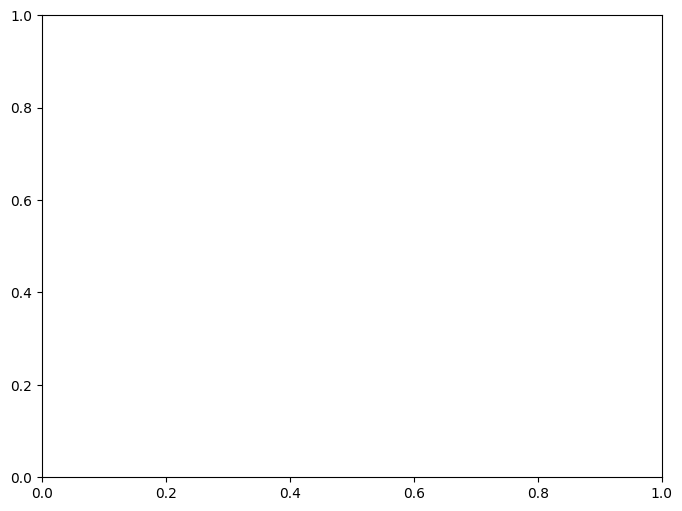

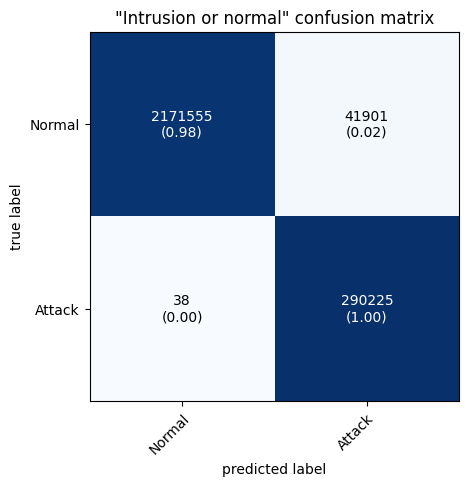

Combining predicted "attack or not" labels to neural network testing data...
Creating neural network...
Training neural network...
Epoch 1/100
282/282 [==============================] - 8s 23ms/step - loss: 2.1510 - accuracy: 0.1552 - categorical_crossentropy: 2.1510
Epoch 2/100
282/282 [==============================] - 10s 35ms/step - loss: 1.8068 - accuracy: 0.3183 - categorical_crossentropy: 1.8068
Epoch 3/100
282/282 [==============================] - 6s 23ms/step - loss: 1.6516 - accuracy: 0.3539 - categorical_crossentropy: 1.6516
Epoch 4/100
282/282 [==============================] - 10s 35ms/step - loss: 1.6353 - accuracy: 0.3608 - categorical_crossentropy: 1.6353
Epoch 5/100
282/282 [==============================] - 6s 23ms/step - loss: 1.6282 - accuracy: 0.3641 - categorical_crossentropy: 1.6282
Epoch 6/100
282/282 [==============================] - 9s 30ms/step - loss: 1.6233 - accuracy: 0.3645 - categorical_crossentropy: 1.6233
Epoch 7/100
282/282 [========================

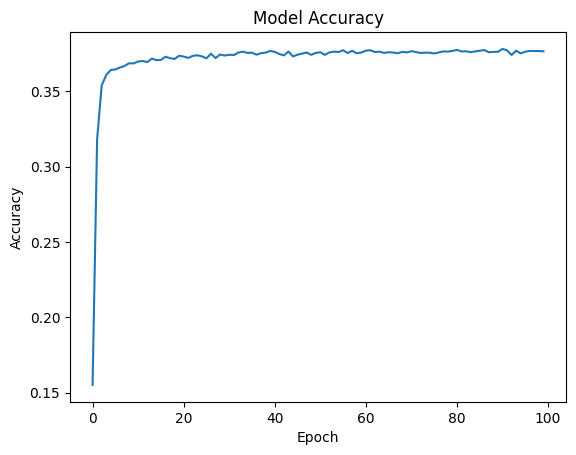

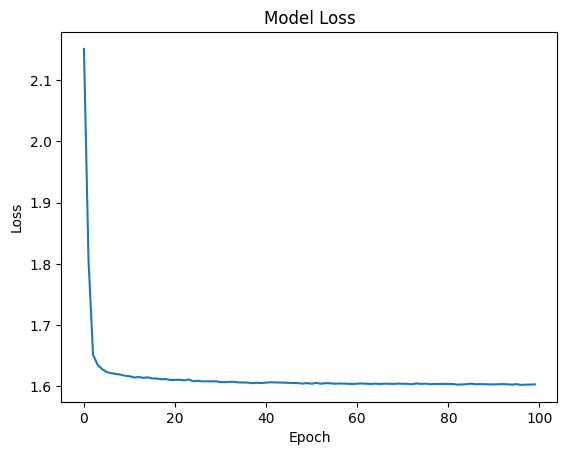

Testing neural network...
78242/78242 [==============================] - 346s 4ms/step
Neural Network Accuracy:  0.8740253998152349
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       268
           1       1.00      0.00      0.00       233
           2       0.04      0.80      0.07     11353
           3       0.30      0.05      0.08     39525
           4       0.15      0.55      0.24     19246
           5       0.02      0.00      0.00    210481
           6       1.00      0.98      0.99   2213456
           7       0.00      0.00      0.00      8987
           8       1.00      0.00      0.00       152
           9       1.00      0.00      0.00        18

    accuracy                           0.87   2503719
   macro avg       0.55      0.24      0.14   2503719
weighted avg       0.89      0.87      0.88   2503719



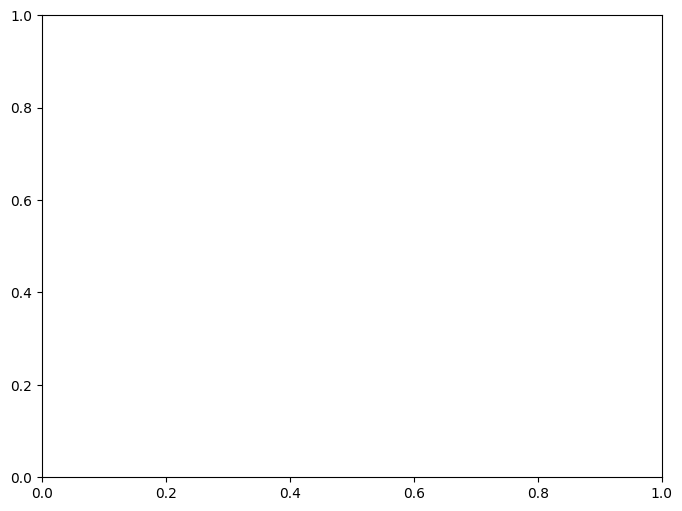

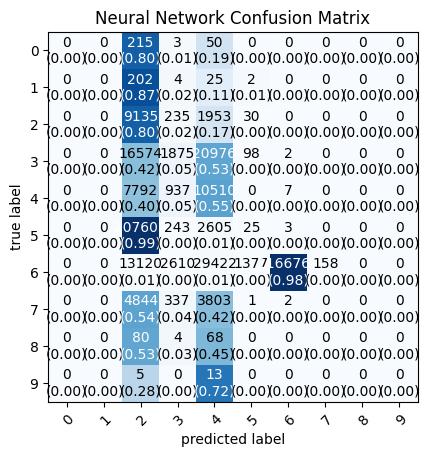

Saving neural network model...
Saving X and Y to HDF5


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, Add, Lambda
from keras.models import Model
from keras.optimizers import SGD
import numpy as np
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.regularizers import l2 as activity_l2
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# Enable memory growth for GPUs (optional)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print('Loading normalized data from HDF5...')
h5f = h5py.File('datasets.h5', 'r')
X_train = h5f['X_nn_train'][:]
Y_train = h5f['Y_nn_train'][:].astype(np.float32)
X_test = h5f['X_nn_test'][:]
Y_test = h5f['Y_nn_test'][:].astype(np.float32)

X_train2 = h5f['X_rf_train'][:]
Y_train2 = h5f['Y_rf_train'][:].astype(np.float32)
X_test2 = h5f['X_rf_test'][:]
Y_test2 = h5f['Y_rf_test'][:].astype(np.float32)

h5f.close()

# Train ExtraTreesClassifier for "attack or not" labels
print('Training ExtraTreesClassifier for "attack or not" labels...')
model2 = ExtraTreesClassifier(n_estimators=31, criterion='entropy')
model2 = model2.fit(X_train2, Y_train2)

Y_pred2 = model2.predict_proba(X_test2)[:, 1]

print('Testing accuracy...')
score2 = accuracy_score(Y_test2, np.around(Y_pred2))
print(score2)
print(classification_report(Y_test2, np.around(Y_pred2)))

# Performance Measure
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i] == y_hat[i] == 1:
            TP += 1
    for i in range(len(y_hat)):
        if y_hat[i] == 1 and y_actual[i] != y_hat[i]:
            FP += 1
    for i in range(len(y_hat)):
        if y_actual[i] == y_hat[i] == 0:
            TN += 1
    for i in range(len(y_hat)):
        if y_hat[i] == 0 and y_actual[i] != y_hat[i]:
            FN += 1

    return (TP, FP, TN, FN)

TP, FP, TN, FN = perf_measure(np.around(Y_pred2), Y_test2)

accuracy = (TN + TP) / (TN + FP + TP + FN)
precision = TP / (TN + FP)
hitrate = TP / (TN + FN)

print('TP:', TP, 'FP:', FP, 'TN:', TN, 'FN:', FN)
print('Accuracy:', accuracy)
print('False Positive rate:', FP / (TN + FP), 'True Negative Rate', TN / (TN + FP))

# Plot confusion matrix
cm = confusion_matrix(Y_test2, np.round(Y_pred2))
fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True, class_names=['Normal', 'Attack'])
plt.title('"Intrusion or normal" confusion matrix')
plt.show()

# Neural Network part
print('Combining predicted "attack or not" labels to neural network testing data...')
X_test = np.concatenate((Y_pred2[:, np.newaxis], X_test), axis=1)

print('Creating neural network...')
num_of_features = X_train.shape[1]
nb_classes = Y_train.shape[1]

def residual_layer(size, x):
    y = Dense(size, activation='sigmoid', kernel_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01))(x)
    y = Dense(x.shape[1], activation='sigmoid', kernel_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01))(y)
    res = Add()([y, x])  # Using Add instead of merge
    return res

def baseline_model():
    def branch2(x):
        x = Dense(int(np.floor(num_of_features * 50)), kernel_initializer='uniform', activation='sigmoid')(x)
        x = Dropout(0.75)(x)

        x = Dense(int(np.floor(num_of_features * 20)), kernel_initializer='uniform', activation='sigmoid')(x)
        x = Dropout(0.5)(x)

        x = Dense(int(np.floor(num_of_features)), kernel_initializer='uniform', activation='sigmoid')(x)
        x = Dropout(0.1)(x)
        return x

    main_input = Input(shape=(num_of_features,), name='main_input')

    x = main_input
    x = branch2(x)
    main_output = Dense(nb_classes, activation='softmax')(x)
    model = Model(inputs=main_input, outputs=main_output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'categorical_crossentropy'])
    return model

model = baseline_model()

print('Training neural network...')
history = model.fit(X_train, Y_train, epochs=100, batch_size=128)

print('Plotting training history data...')
print(history.history.keys())

# Plot training history
plt.figure()
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.figure()
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Testing neural network
print('Testing neural network...')
Y_predicted = model.predict(X_test)

max_probs = np.argmax(Y_predicted, axis=1)
Y_pred = np.zeros(Y_predicted.shape)
for row, col in enumerate(max_probs):
    Y_pred[row, col] = 1

score = accuracy_score(Y_test, Y_pred)
print("Neural Network Accuracy: ", score)
print(classification_report(Y_test.argmax(axis=-1), Y_pred.argmax(axis=-1), zero_division=1))

# Plot confusion matrix for neural network
cm_nn = confusion_matrix(Y_test.argmax(axis=-1), Y_pred.argmax(axis=-1))
fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(conf_mat=cm_nn, show_absolute=True, show_normed=True, class_names=list(range(nb_classes)))
plt.title('Neural Network Confusion Matrix')
plt.show()

# Saving neural network model
print('Saving neural network model...')
json_string = model.to_json()
with open('neural_model1.json', 'w') as f:
    f.write(json_string)
model.save_weights('neural_model_weights1.h5')

model.save('neural_model1.h5')

# Save results to HDF5
print('Saving X and Y to HDF5')
h5f = h5py.File('results.h5', 'w')
h5f.create_dataset('Y_predicted', data=Y_pred)
h5f.create_dataset('Y_expected', data=Y_test)
h5f.close()
